### Code to plot a telemetry profile (Beta!)
#### 2021 01 28 CJH

In [318]:
from networktables import NetworkTables
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pickle
import glob
from importlib import reload

In [303]:
import telemetry_plot_utils as tpu 
from telemetry_plot_utils import load_file

#### load data from pickle files in the /robot/sim/data folder

In [453]:
# get a list of all the files 
data_files = glob.glob('../robot/sim/data/*')
data_files

['../robot/sim/data\\20210129_151537_loop_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_152347_test_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_152827_slalom_points_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_155645_slalom_points_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_155931_slalom_points_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_160857_slalom_points_kpvel_0p0vel_1.pkl',
 '../robot/sim/data\\20210129_162203_slalom_points_kpvel_0p0vel_0.5.pkl',
 '../robot/sim/data\\20210129_163257_loop_kpvel_0p0vel_1.5.pkl',
 '../robot/sim/data\\20210129_185651_slalom_pathweaver_kpvel_0p0vel_0.75.pkl',
 '../robot/sim/data\\20210129_214320_slalom_pathweaver_kpvel_0p2vel_1.0.pkl',
 '../robot/sim/data\\20210129_214826_slalom_pathweaver_kpvel_0p5vel_1.0.pkl',
 '../robot/sim/data\\20210129_215448_slalom_pathweaver_kpvel_0p7vel_1.0.pkl',
 '../robot/sim/data\\20210129_220724_slalom_pathweaver_kpvel_0p7vel_1.0.pkl',
 '../robot/sim/data\\20210129_221236_slalom_pathweaver_k

In [305]:
infile = data_files[-1]
telemetry = tpu.load_file(infile)

#### convert data to table, add vector data and correct for field starting point offsets

In [306]:
df = fix_data(telemetry, x_offset=1.2, y_offset=0.9) # starting offsets for 

#### take a quick look at the pandas datatable from the odometry

In [390]:
# want to do typical python slicing but that does not work with pandas so use a little logic to cut down the table for displaying here
df[(df.index) % 50 == 0].round(2)

TIME  RBT_X  RBT_Y  RBT_TH  RBT_VEL  RBT_RVEL  RBT_LVEL  TRAJ_X  TRAJ_Y  \
0     0.08   1.30   0.96    0.00     0.00      0.00      0.00    1.31    0.96   
50    5.08   3.50   2.72    0.43     0.79      0.71      0.87    3.51    2.87   
100  10.08   6.32   2.20   -1.06     0.62      0.70      0.53    6.38    2.23   
150  15.08   8.59   1.56    0.68     0.60      0.48      0.72    8.71    1.43   
200  20.08   7.13   2.40   -2.46     0.47      0.37      0.58    7.05    2.56   
250  25.08   5.04   1.12   -3.02     0.73      0.67      0.78    4.97    0.92   
300  30.08   2.28   2.22    2.26     0.75      0.61      0.89    2.09    2.20   

     TRAJ_TH  ...  RAM_LVEL_SP  RAM_RVEL_SP  RAM_OM   LFF   RFF  LPID  RPID  \
0       0.01  ...         0.07         0.09    0.02  1.30  1.33   0.0   0.0   
50      0.61  ...         0.70         0.73    0.05  2.64  2.71   0.0   0.0   
100    -0.96  ...         0.68         0.75    0.10  2.60  2.75   0.0   0.0   
150     0.91  ...        -0.03         0.83    1.25 -1.20  2.93   0.0   0.0   
200    -2.47  ...         0.37         0.47    0.15  1.93  2.15   0.0   0.0   
250    -3.14  ...         0.84         0.85    0.02  2.95  2.98   0.0   0.0   
300     2.29  ...         0.58         0.98    0.58  2.38  3.24   0.0   0.0   

     DELTA  VEC_X  VEC_Y  
0     0.00   0.00   0.00  
50    0.08   0.07   0.03  
100   0.06   0.03  -0.05  
150   0.06   0.05   0.04  
200   0.05  -0.04  -0.03  
250   0.07  -0.07  -0.01  
300   0.07  -0.05   0.06  

[7 rows x 22 columns]

In [473]:
df_points = tpu.get_points_df(name='bounce')
df_points.head()

X         Y  Tangent X  Tangent Y  Fixed Theta  Reversed  Name
0  1.270459  2.621777   0.901575   0.126982         True     False   NaN
1  2.121240  3.155103   0.244387   0.450954        False     False   NaN
2  2.248223  3.790015   0.190474   1.447599         True     False   NaN
3  2.375205  3.523352   0.139681  -0.584119         True     False   NaN
4  2.959324  1.847185   0.304758  -0.380947         True     False   NaN

In [379]:
# get the points used to generate the trajectory
df_points = tpu.get_points_df(name='slalom')
df_points.head()

X         Y  Tangent X  Tangent Y  Fixed Theta  Reversed  Name
0  1.308553  0.958308   0.443237   0.002638         True     False   NaN
1  2.324412  1.453540   0.406344   0.723799         True     False   NaN
2  3.352969  2.748760   1.989482   1.595004         True     False   NaN
3  5.956108  2.685268   1.206758  -0.900119         True     False   NaN
4  7.568784  0.958308   1.285491   0.081475         True     False   NaN

#### make plots from robot telemetry data

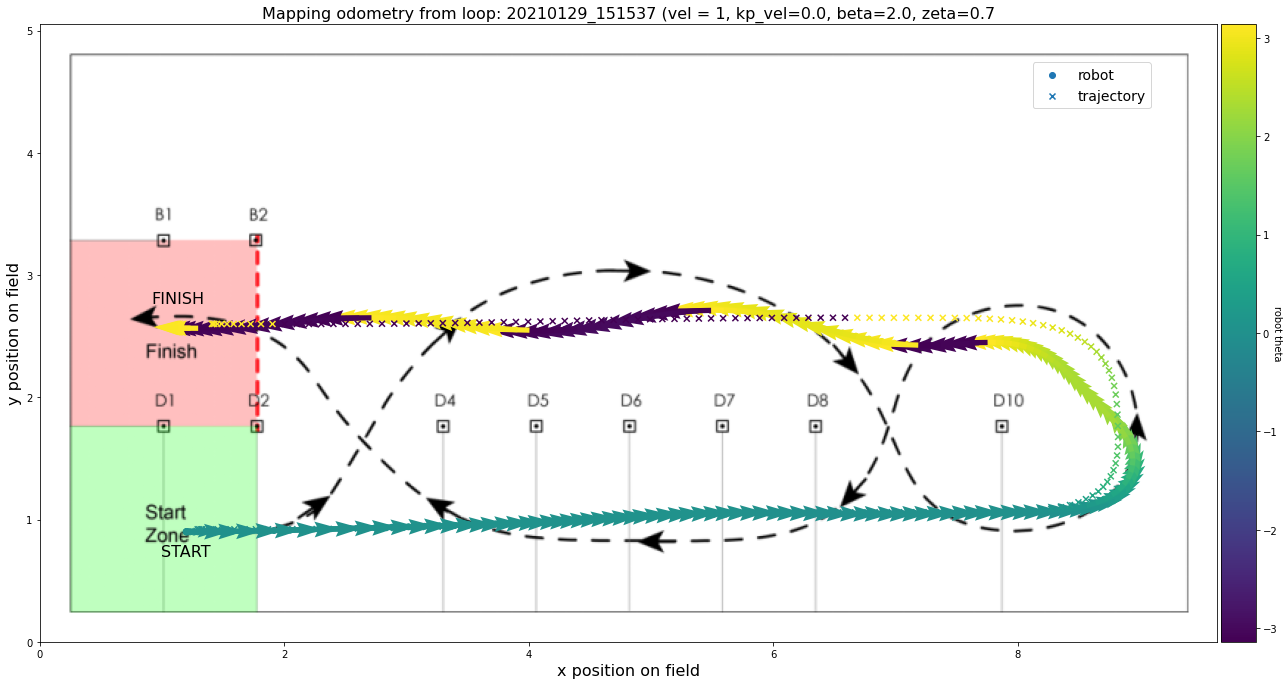

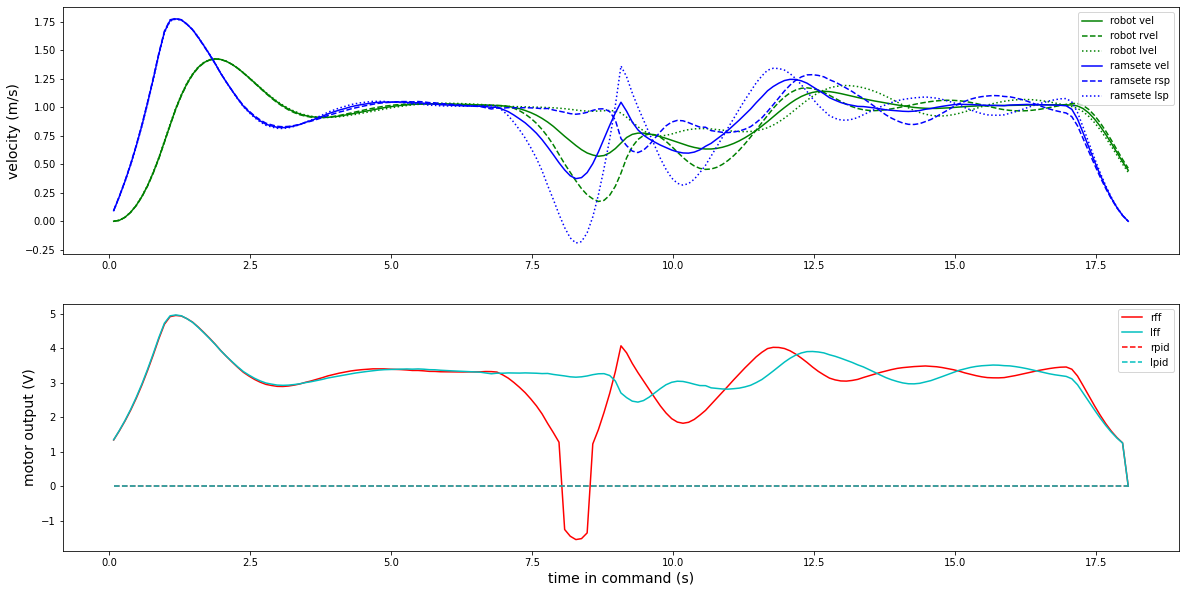

In [457]:
reload(tpu)
df_loop, telemetry_loop = tpu.get_data(file_name='20210129_151537', x_offset=1.2, y_offset=0.9)
tpu.plot_df(df_loop, telemetry_loop, point_df=None, arrows=True, save=False)
tpu.velocity_plot(df_loop)

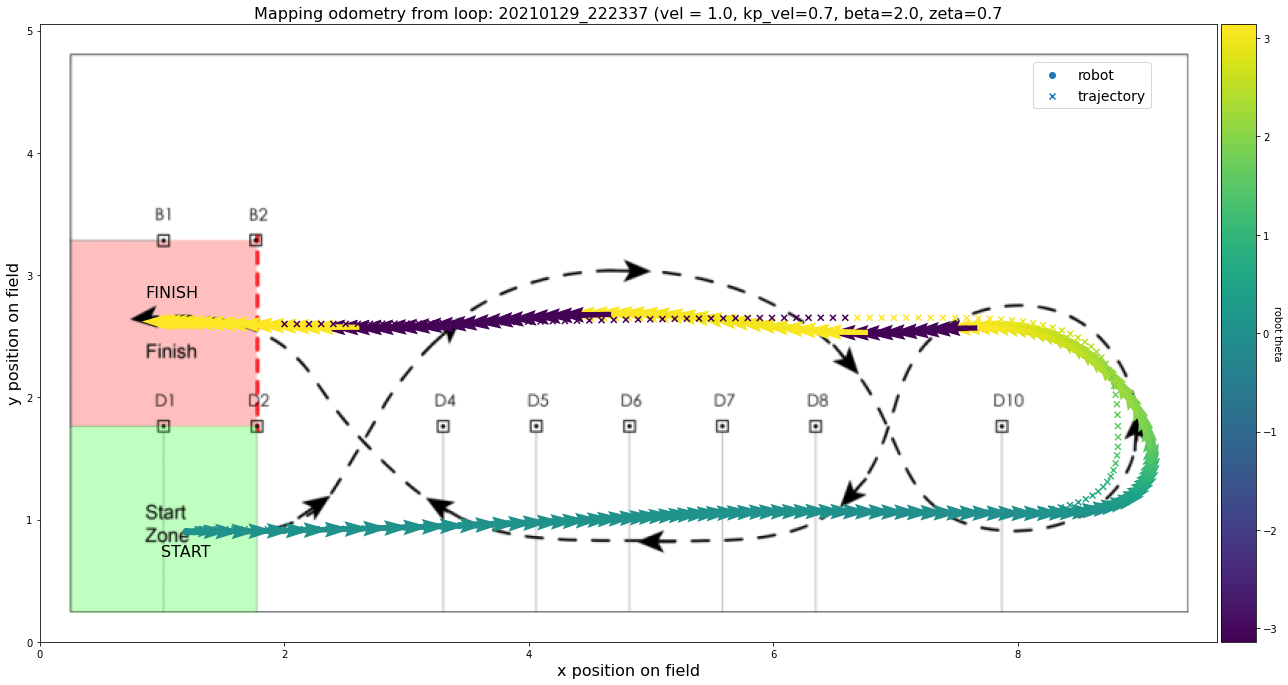

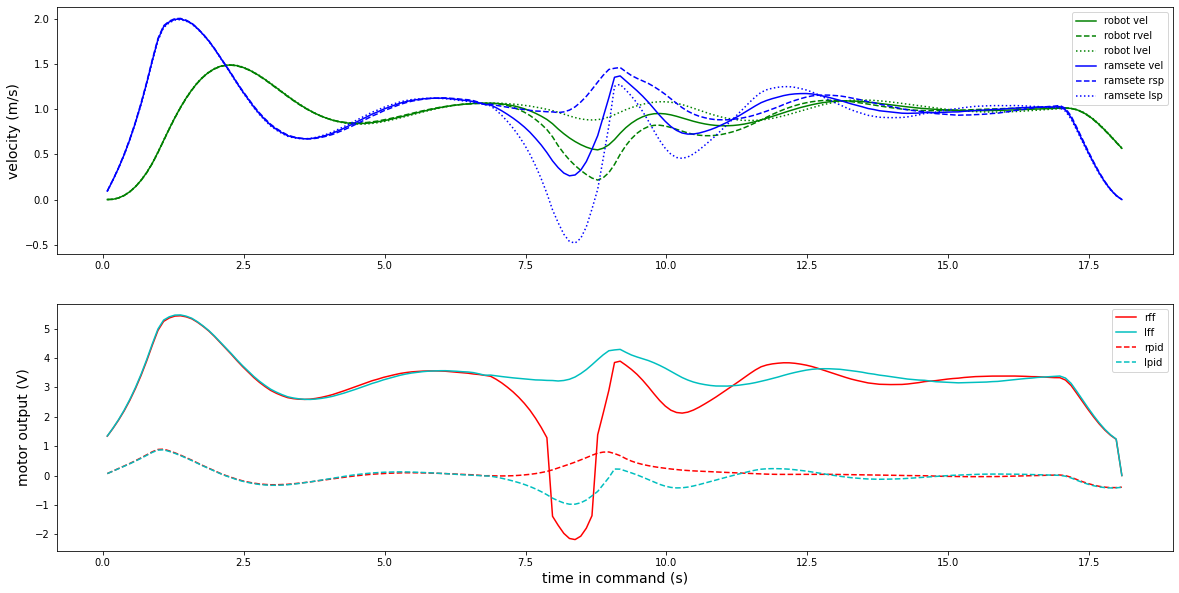

In [458]:
reload(tpu)
df_loop2, telemetry_loop2 = tpu.get_data(file_name='20210129_222337', x_offset=1.2, y_offset=0.9)
tpu.plot_df(df_loop2, telemetry_loop2, point_df=None, arrows=True, save=False)
tpu.velocity_plot(df_loop2)

## 0.75 on pathweaver - 32 second trajectory 

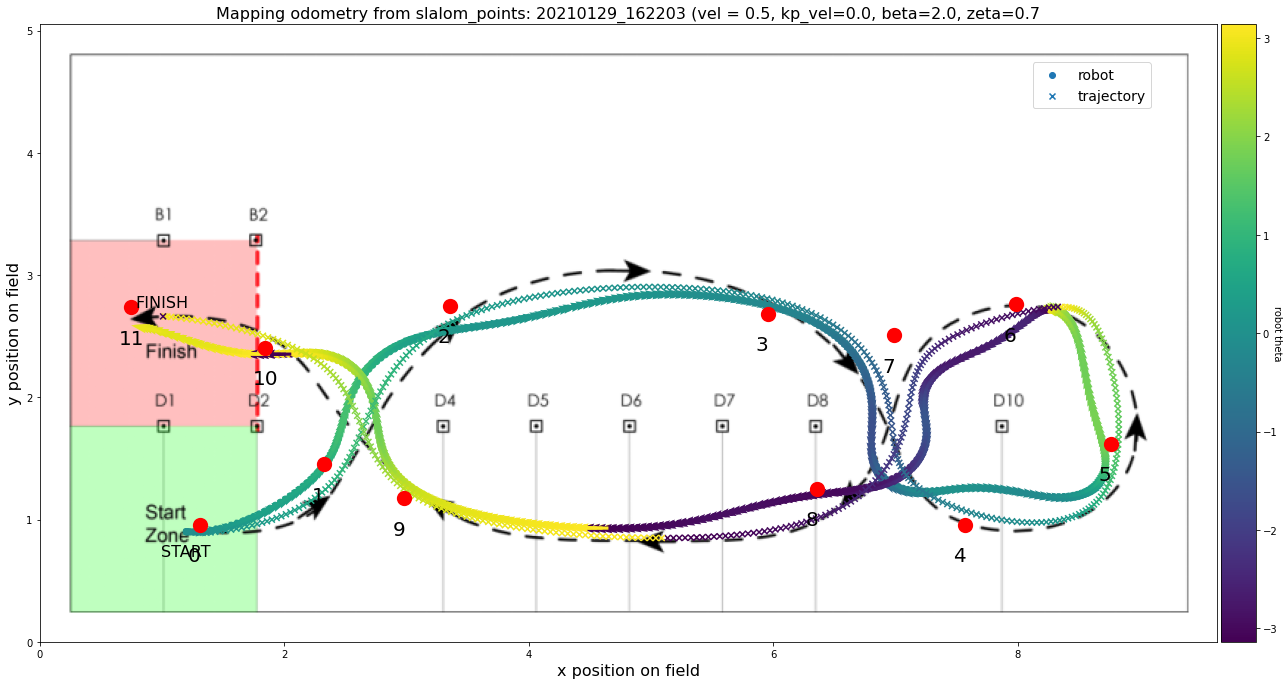

In [459]:
reload(tpu)
df_slalom_pts, telemetry_slalom_pts = tpu.get_data(file_name='20210129_162203', x_offset=1.2, y_offset=0.9)
tpu.plot_df(df_slalom_pts, telemetry_slalom_pts, point_df=df_points, arrows=True, save=False)

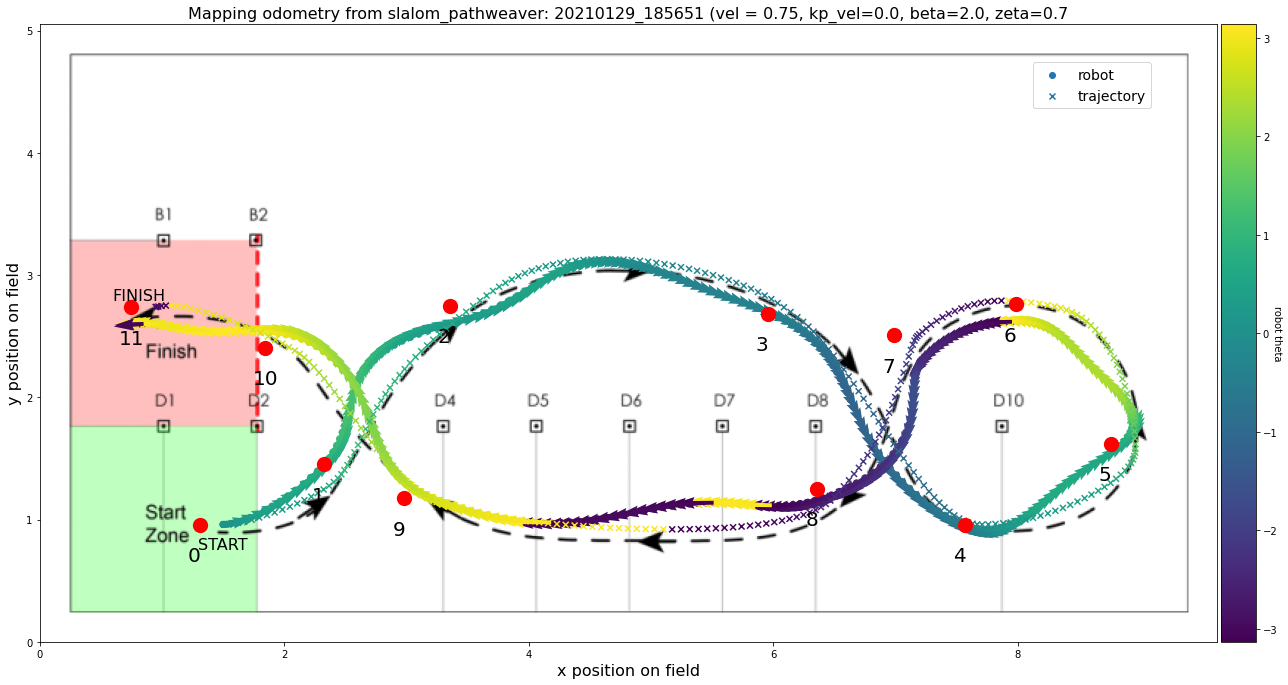

In [460]:
reload(tpu)
df_slalom_points = tpu.get_points_df(name='slalom')
df_slalom_weave, telemetry_slalom_weave = tpu.get_data(file_name='20210129_185651', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave, telemetry_slalom_weave, point_df=df_slalom_points, arrows=True, save=False)

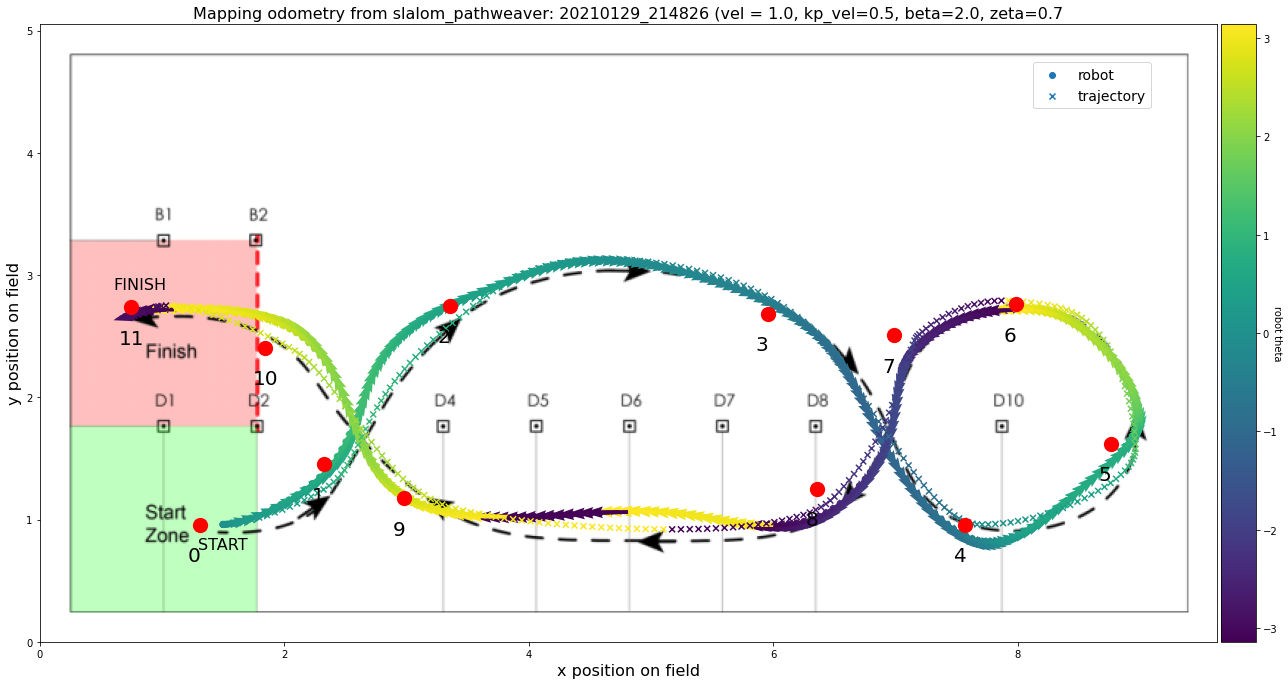

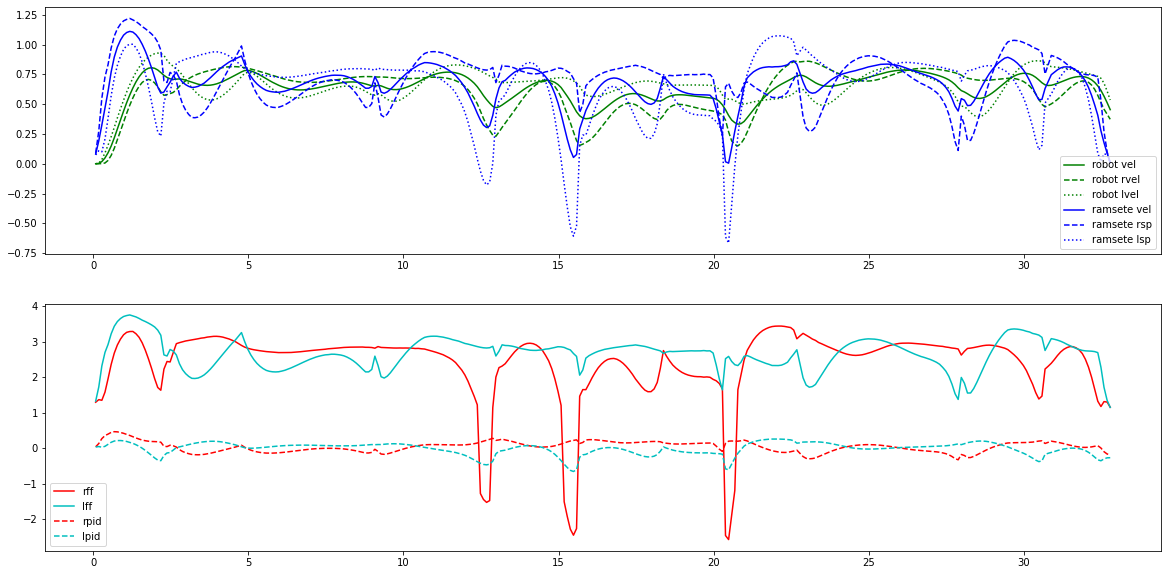

In [462]:
reload(tpu)
df_slalom_points = tpu.get_points_df(name='slalom')
df_slalom_weave2, telemetry_slalom_weave2 = tpu.get_data(file_name='20210129_214826', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave2, telemetry_slalom_weave2, point_df=df_slalom_points, arrows=True, save=False)
velocity_plot(df_slalom_weave2)

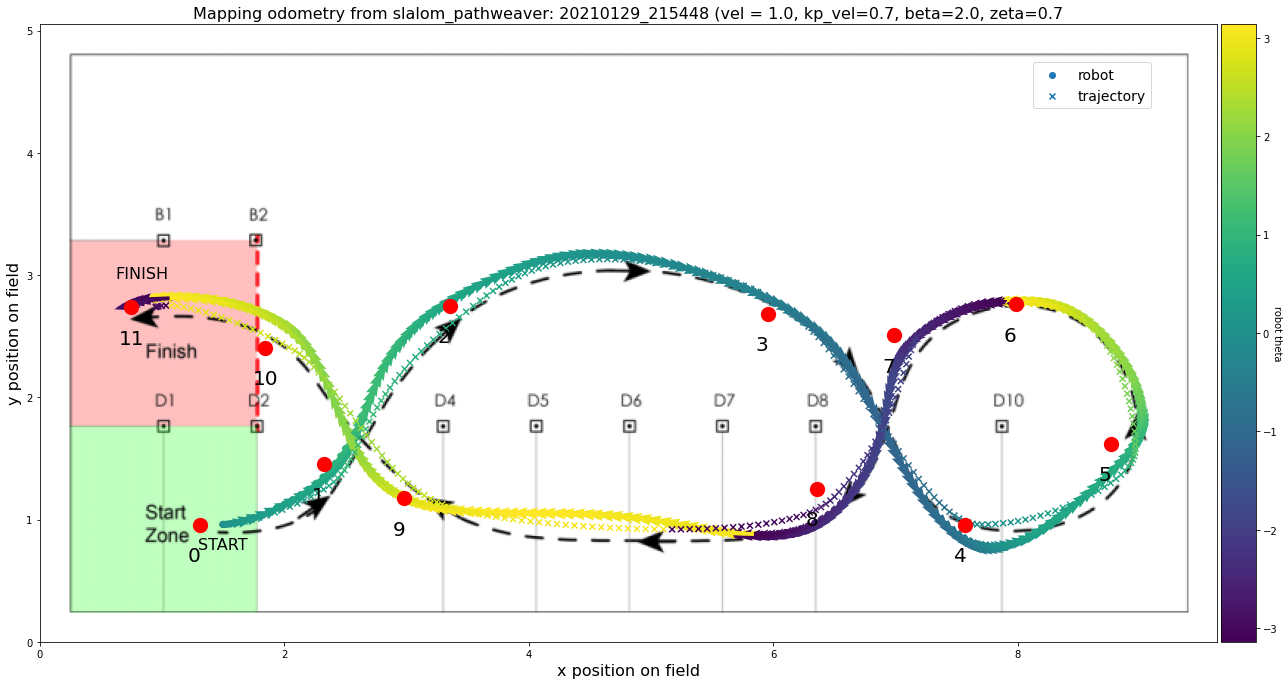

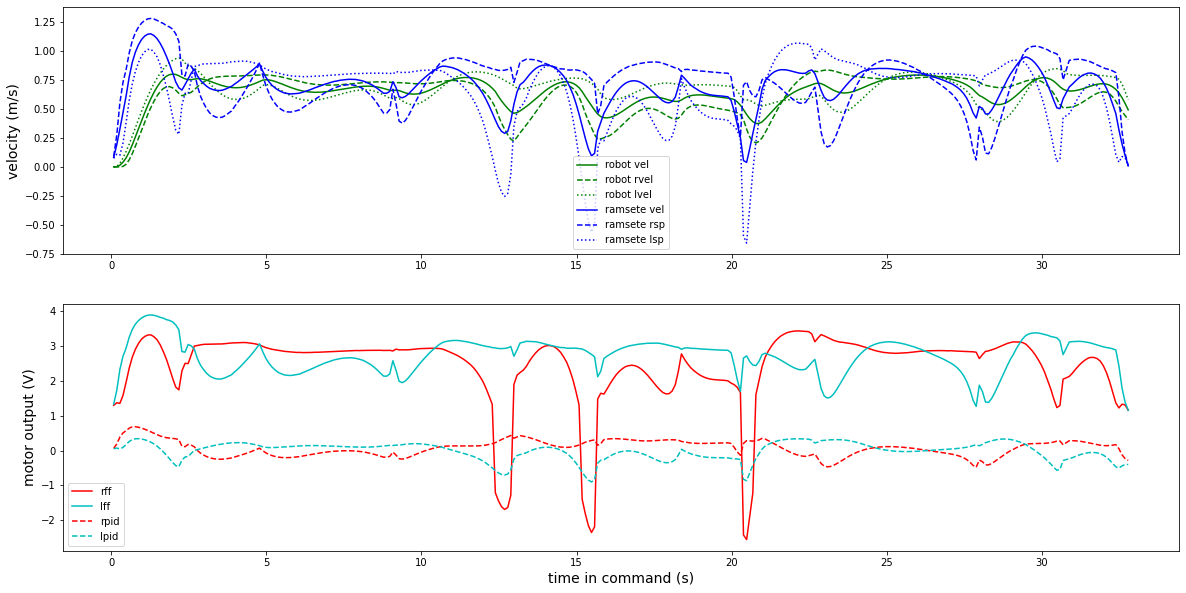

In [463]:
reload(tpu)
df_slalom_points = tpu.get_points_df(name='slalom')
df_slalom_weave3, telemetry_slalom_weave3 = tpu.get_data(file_name='20210129_215448', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave3, telemetry_slalom_weave3, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave3)

#### reversing the sign of the velocity PID controller - making sure that I have it right, and this makes it far worse - PID fights Ramsete

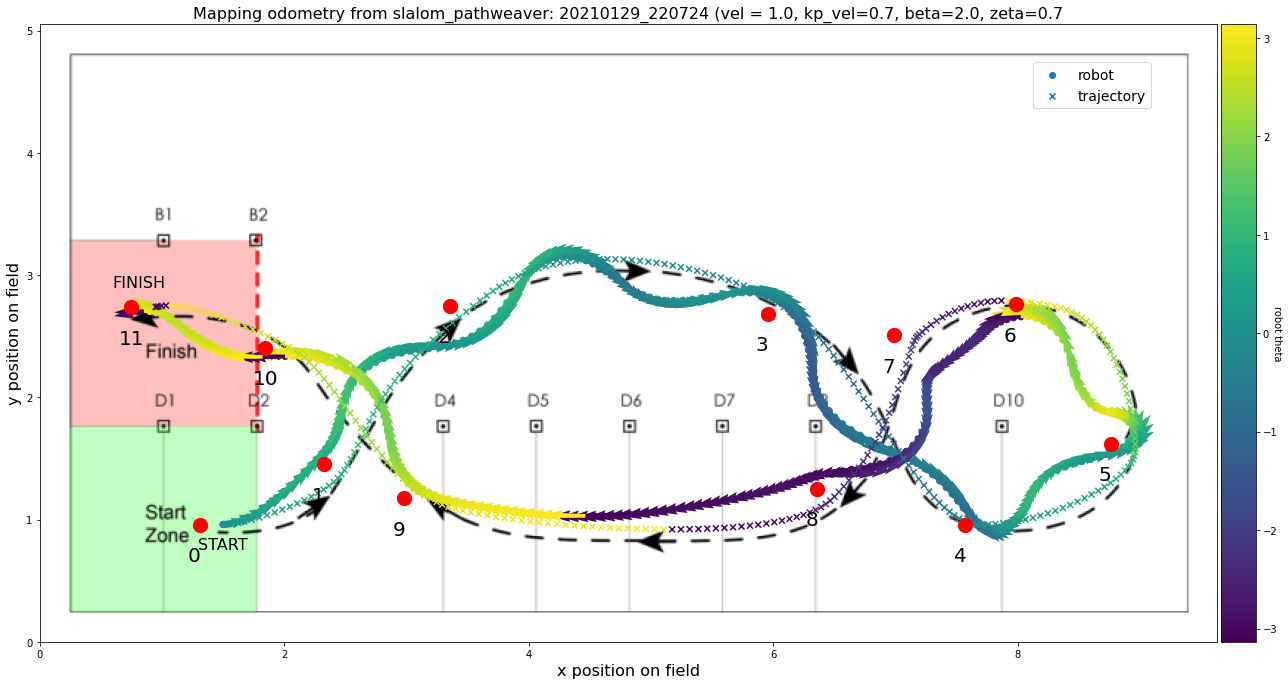

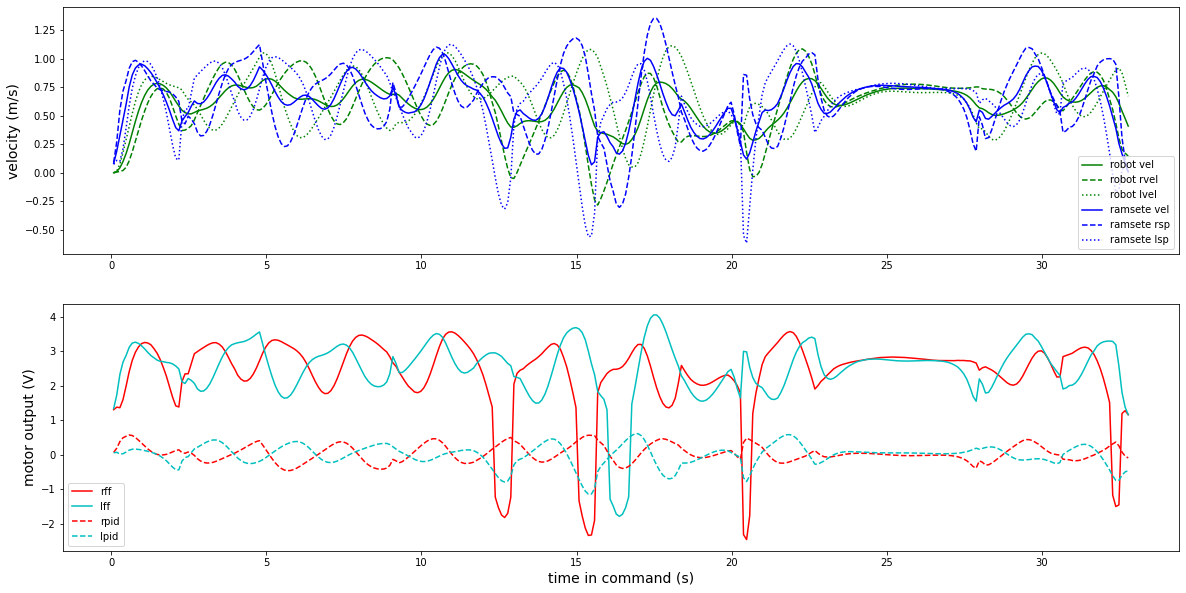

In [464]:
reload(tpu)
df_slalom_points = tpu.get_points_df(name='slalom')
df_slalom_weave4, telemetry_slalom_weave4 = tpu.get_data(file_name='20210129_220724', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave4, telemetry_slalom_weave4, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave4)

#### weird - making kp_vel 1.1 (higher value) now makes it a wider circle.  Doesn't track as well.  
* 0.5 to 0.7 seems the best for it with the default values for the Ramsete

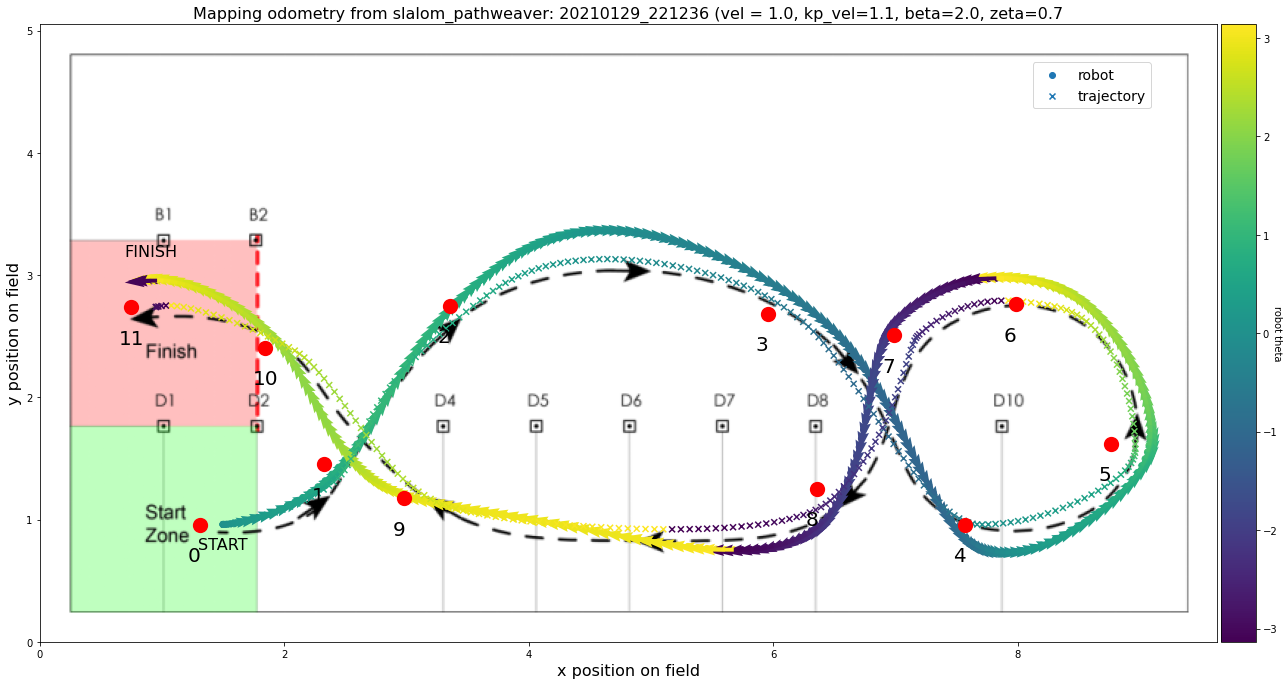

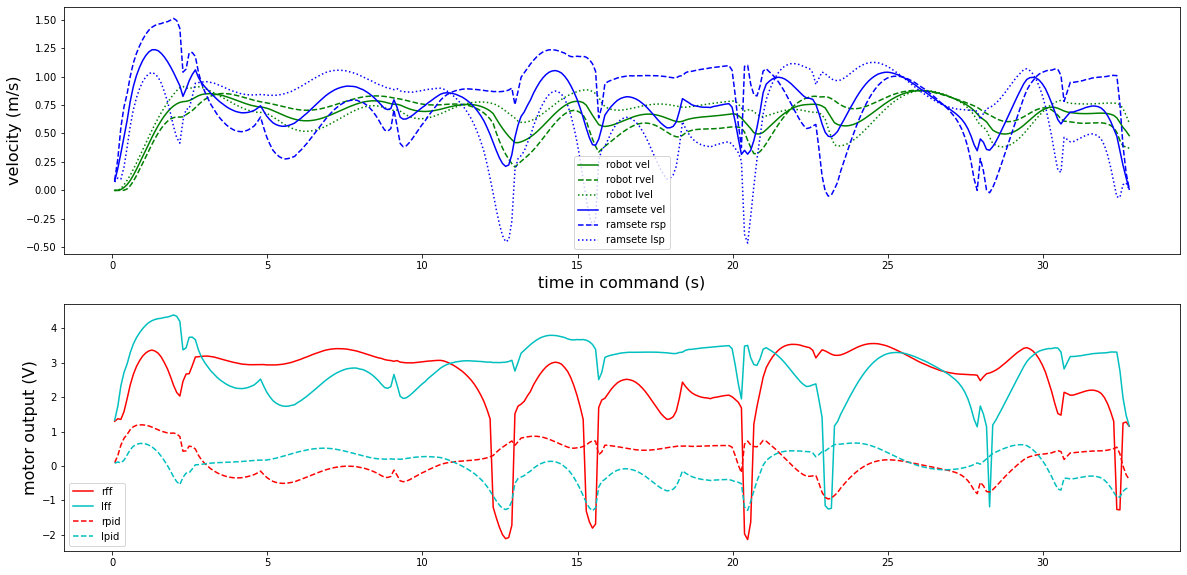

In [456]:
reload(tpu)
df_slalom_weave5, telemetry_slalom_weave5 = tpu.get_data(file_name='20210129_221236', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave5, telemetry_slalom_weave5, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave5)

### speeding it up to 1.25 m/s on the pathweaver trajectory - 21s  (may need a path where we pull in the circle a bit)

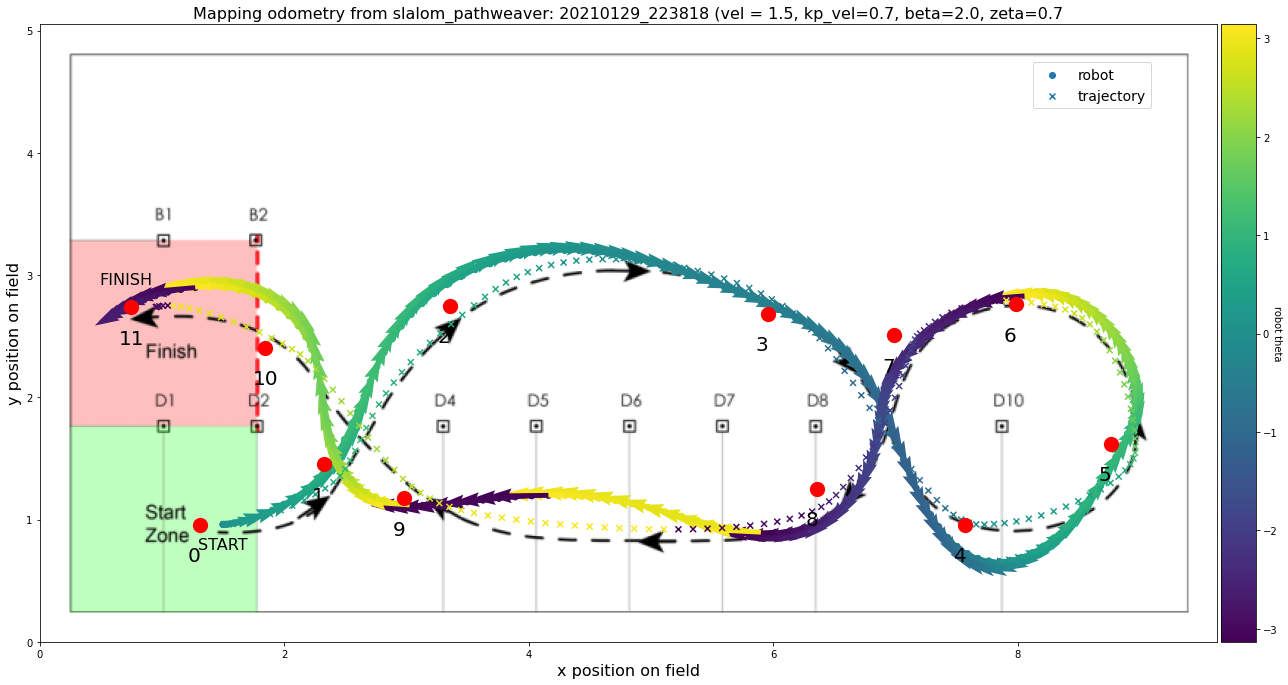

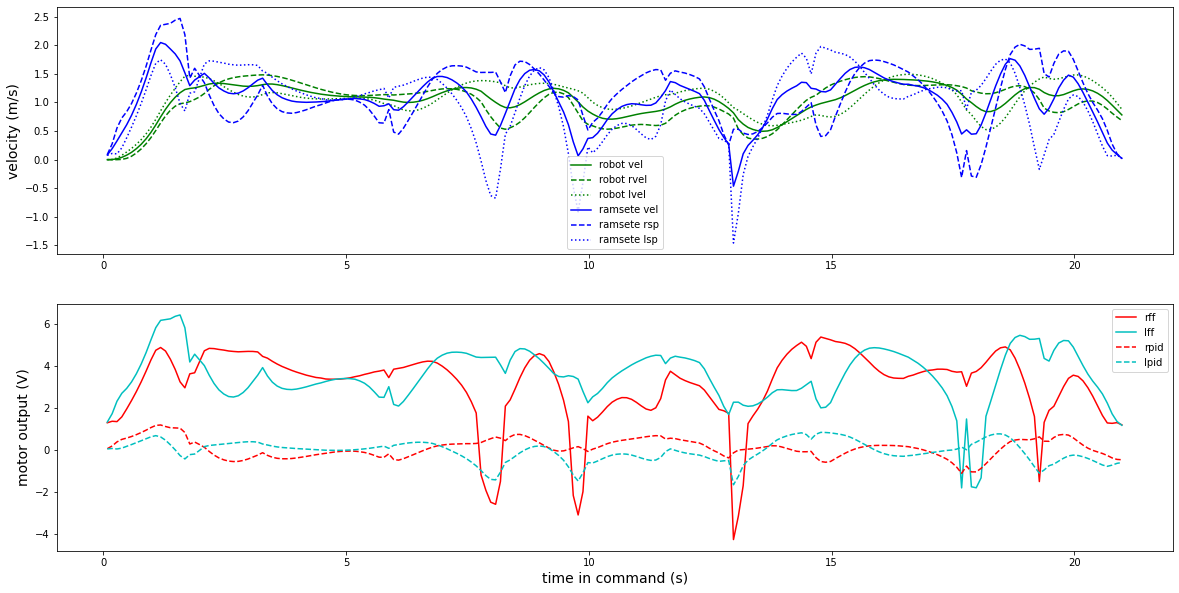

In [465]:
df_slalom_weave6, telemetry_slalom_weave6 = tpu.get_data(file_name='20210129_223818', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave6, telemetry_slalom_weave6, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave6)

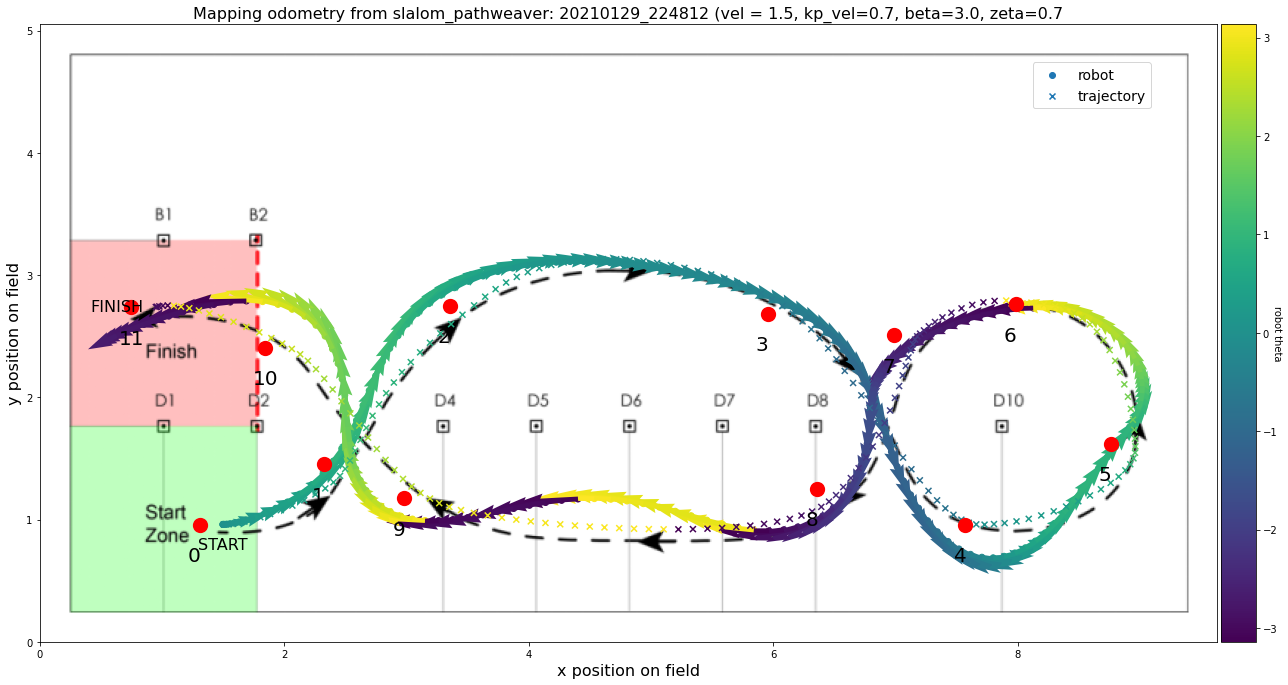

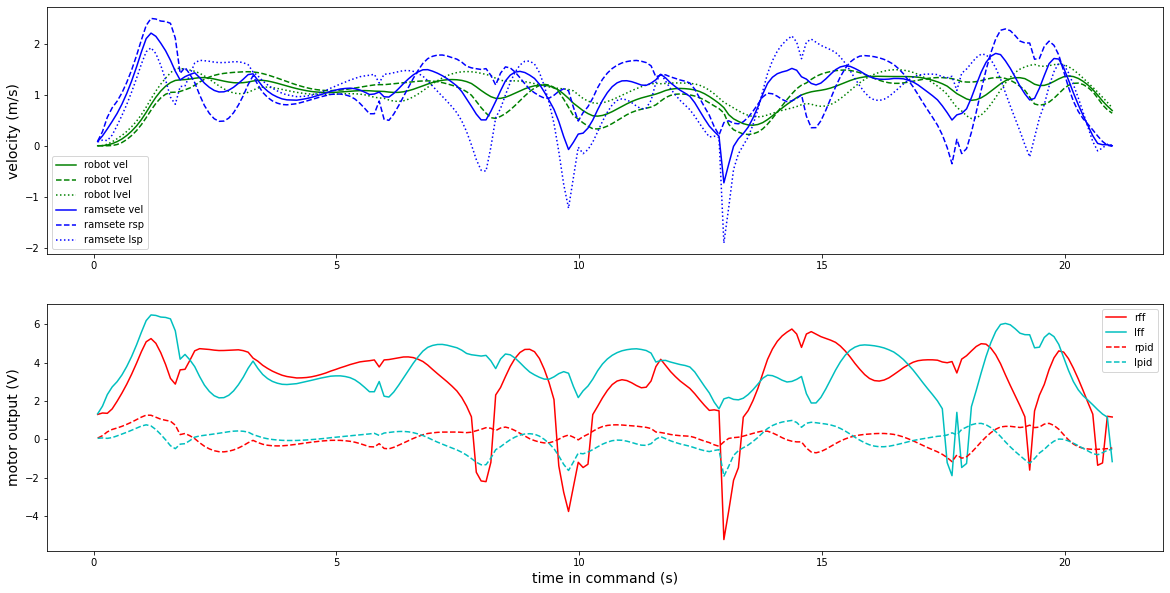

In [469]:
df_slalom_weave7, telemetry_slalom_weave7 = tpu.get_data(file_name='20210129_224812', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave7, telemetry_slalom_weave7, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave7)

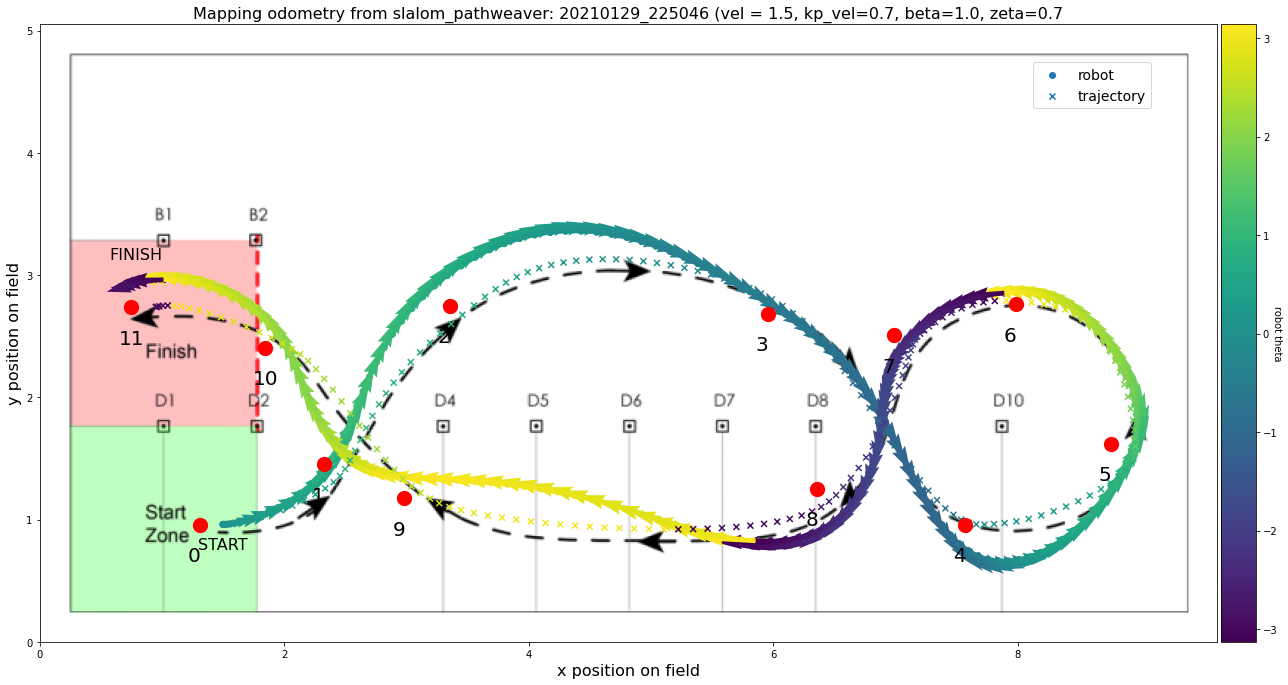

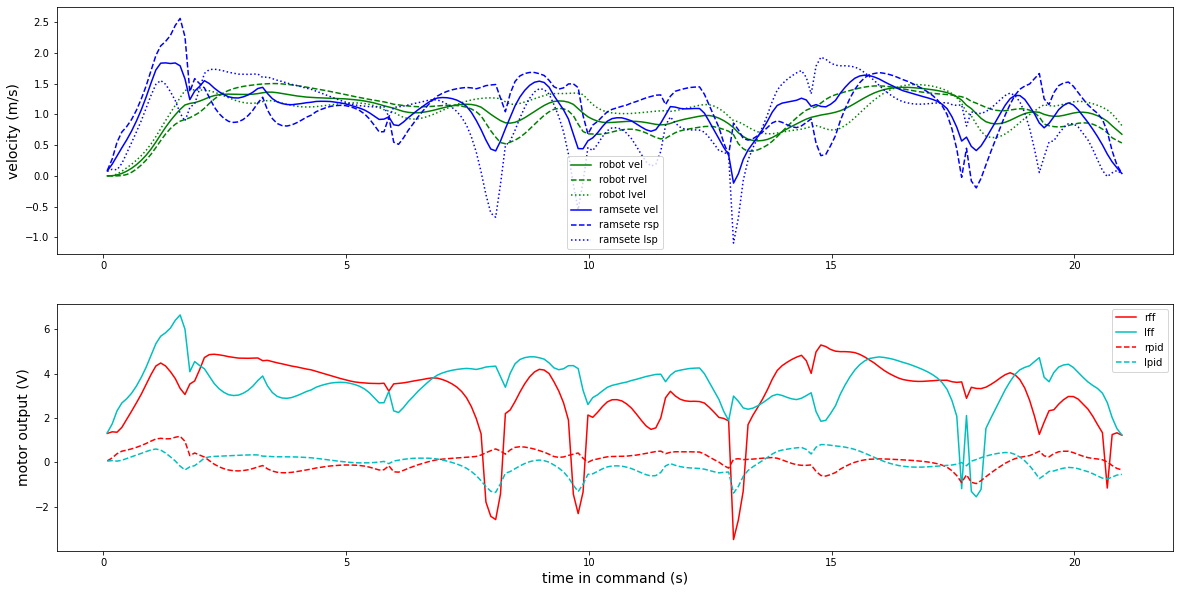

In [470]:
df_slalom_weave8, telemetry_slalom_weave8 = tpu.get_data(file_name='20210129_225046', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave8, telemetry_slalom_weave8, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave8)

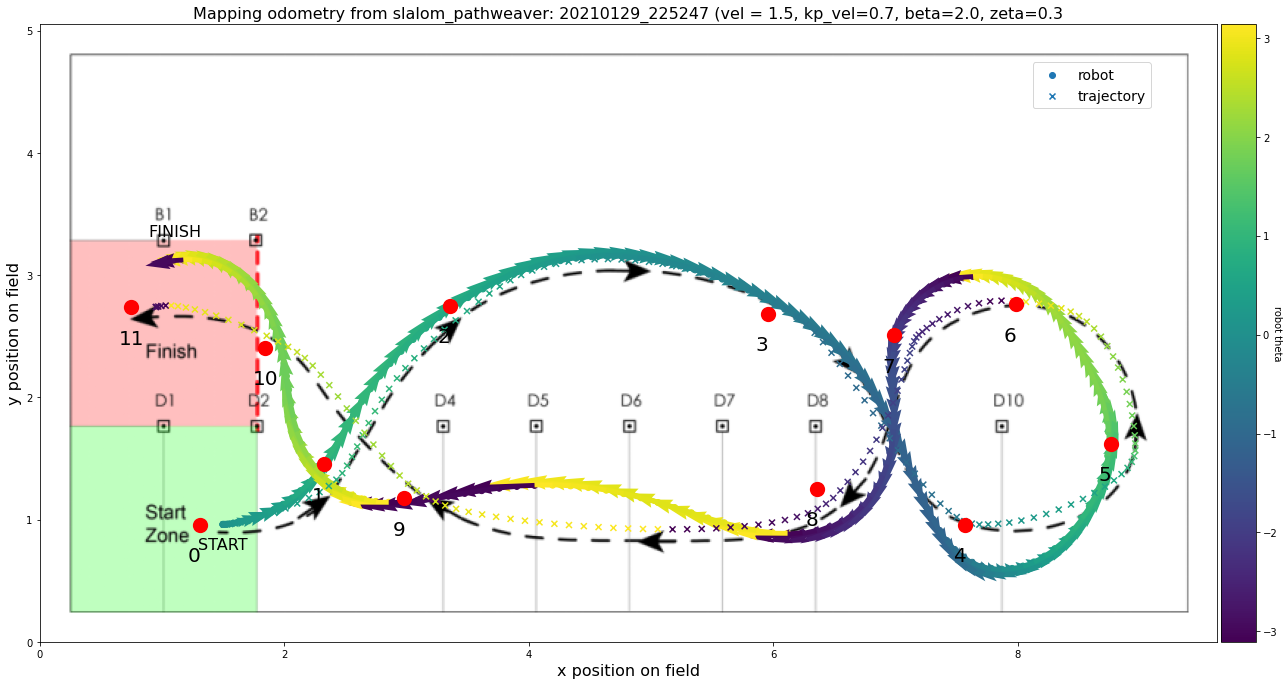

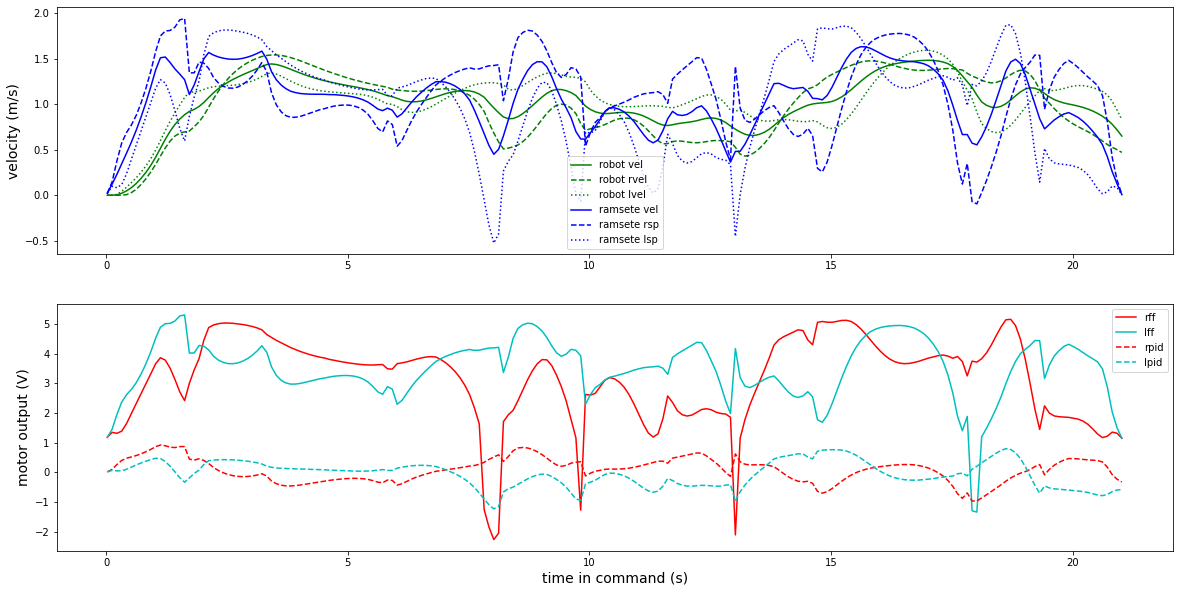

In [471]:
df_slalom_weave9, telemetry_slalom_weave9 = tpu.get_data(file_name='20210129_225247', x_offset=0.2, y_offset=0.3)
tpu.plot_df(df_slalom_weave9, telemetry_slalom_weave9, point_df=df_slalom_points, arrows=True, save=False)
tpu.velocity_plot(df_slalom_weave9)